## Settings

In [1]:
from typing import Any, Dict, List, OrderedDict, Union
import os
from os.path import join as osj
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from matplotlib.collections import LineCollection
import random
import pandas as pd
from workoutdet.data import FrameDataset, reps_to_label, get_rep_data
from workoutdet.utils import plot_all, plot_per_action, plot_hmm, parse_json_score, plot_raw_output,plot_pred
from workoutdet.hmm import hmm_infer
import json

CLASSES = ['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']

COLORS = list(plt.get_cmap('tab20').colors)
plt.style.use('seaborn-dark')
params = {
    'figure.dpi': 300,
    'figure.figsize': (8, 5),
    'figure.autolayout': True,
    'lines.linewidth': 1,
    'axes.prop_cycle': plt.cycler('color', COLORS),
    'font.size': 10,
    'font.family': 'sans-serif',
}

In [2]:
data_root = os.path.expanduser("~/data/RepCount")
anno_path = osj(data_root, "annotation.csv")
data = list(get_rep_data(anno_path, data_root, ['train', 'val', 'test'], ['all']).values())
print(CLASSES)

['situp', 'push_up', 'pull_up', 'jump_jack', 'squat', 'front_raise']


In [3]:
json_dir = os.path.expanduser('../out/acc_0.841_epoch_26_20220711-191616_1x1')
json_files = os.listdir(json_dir)
template  = '{}.stride_1_step_1.json'
print(len(json_files))
print(json_files[0])
print(json.load(open(osj(json_dir, json_files[0]))).keys())

762
stu7_51.mp4.stride_1_step_1.json
dict_keys(['video_name', 'model', 'stride', 'step', 'length', 'fps', 'input_shape', 'checkpoint', 'total_frames', 'ground_truth', 'action', 'scores'])


video: stu3_46.mp4
class: push_up
count: 9
reps: [76, 122, 122, 162, 163, 203, 203, 240, 240, 275, 275, 313, 313, 350, 350, 388, 388, 426]
fps: 29.97002997002997
total_frames: 599


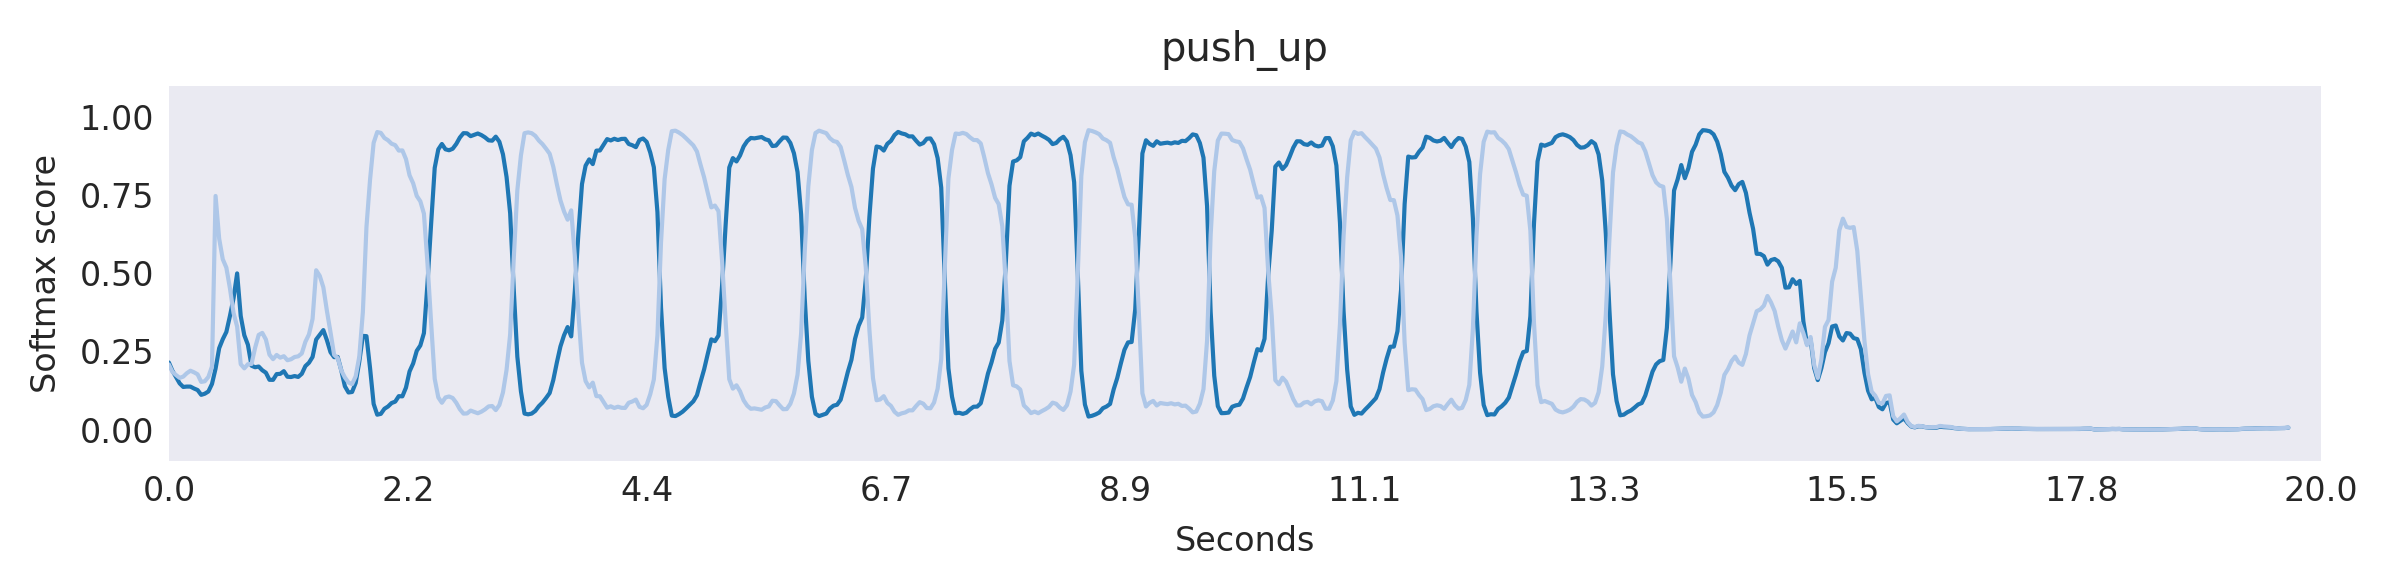

In [4]:
item = random.choice(data)
print(item)
js = json.load(open(osj(json_dir, template.format(item.video_name))))

# plot_all(js['ground_truth'], js, softmax=True, stride=1)
plot_per_action(js, softmax=True, action_only=True)

## Hidden Markov Model

- Input: A sequence of probabilities of shape (seq_len, 12)
- Output: An integer state

In [5]:
from workoutdet.hmm import hmm_infer, hmm_train
from workoutdet.data import FeatureDataset
from workoutdet.evaluate import pred_to_count, major_vote
from torch.utils.data import DataLoader

In [6]:
action = 'jump_jack'
feat_ds = FeatureDataset(json_dir,
                         anno_path,
                         split='train',
                         action=action,
                         window=1,
                         stride=1)
model = hmm_train(action, feat_ds)

jump_jack torch.Size([57119, 1, 12]) num y [0 1 2]


### Predict

(160, 12) [0 0 0 1 1 1 1 1 1 1]
startprob_ (3,)
count 7 name stu4_22.mp4 jump_jack
argmax_smoothed [0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0]


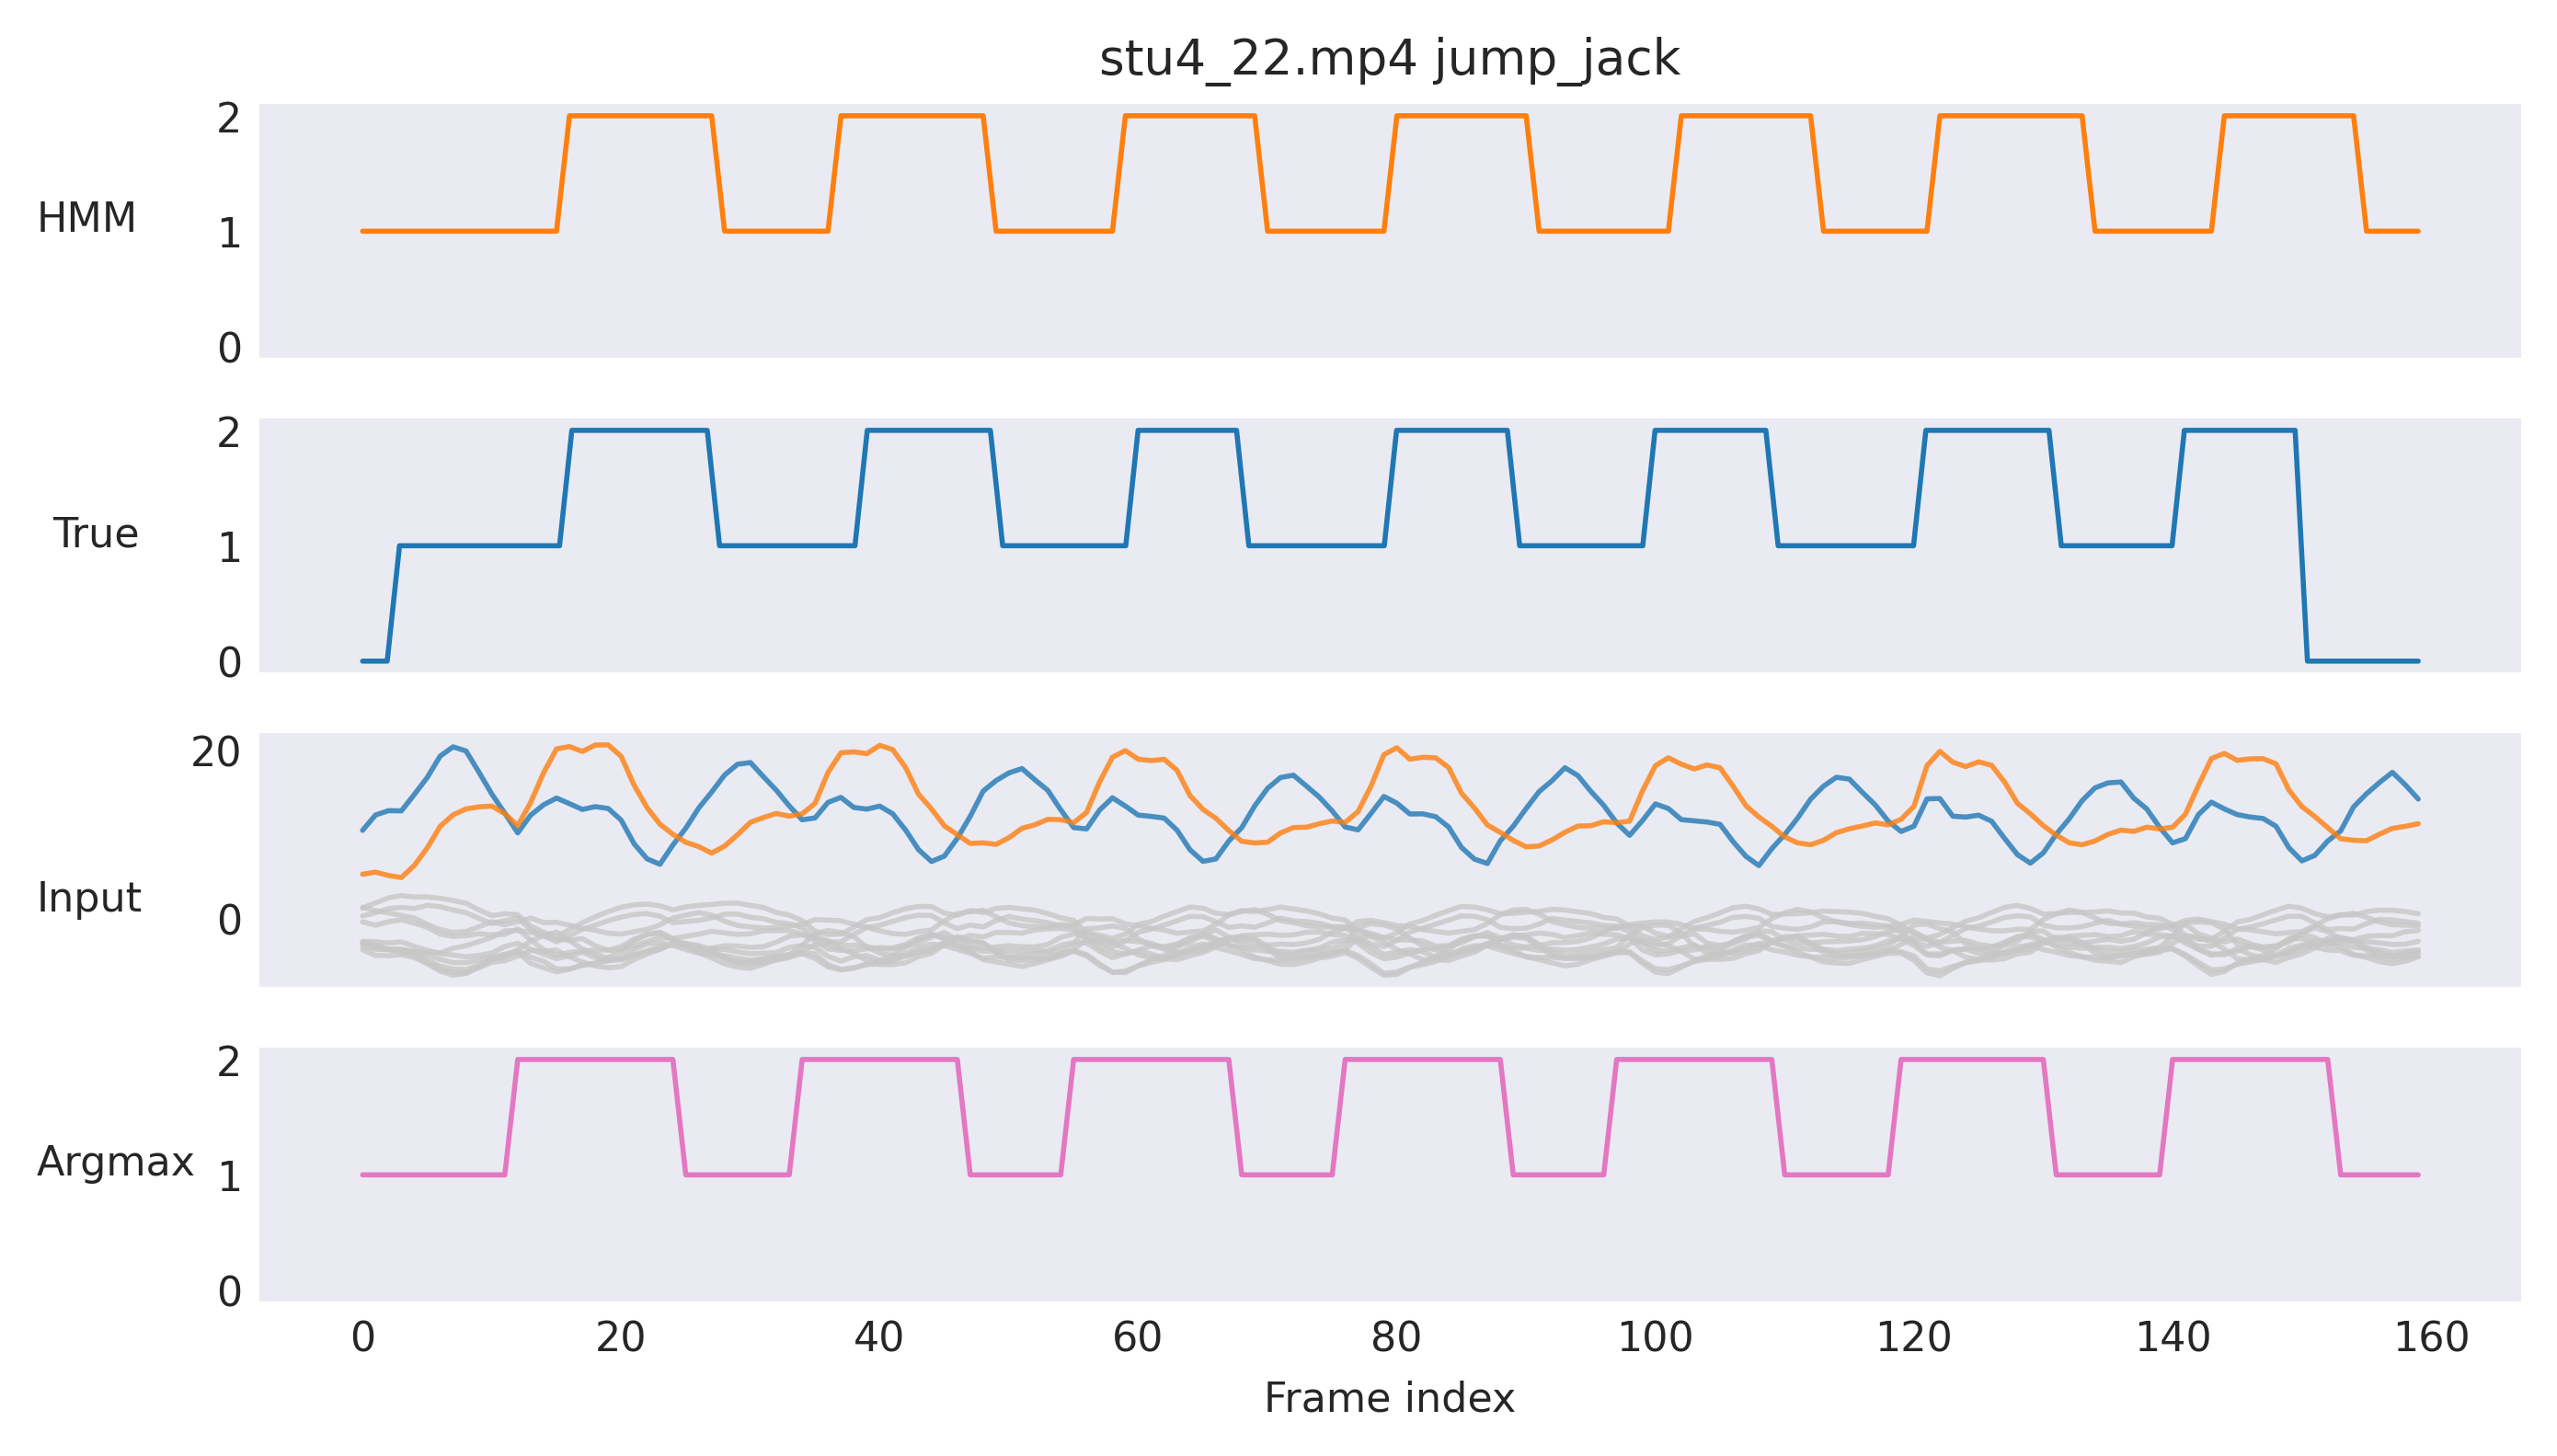

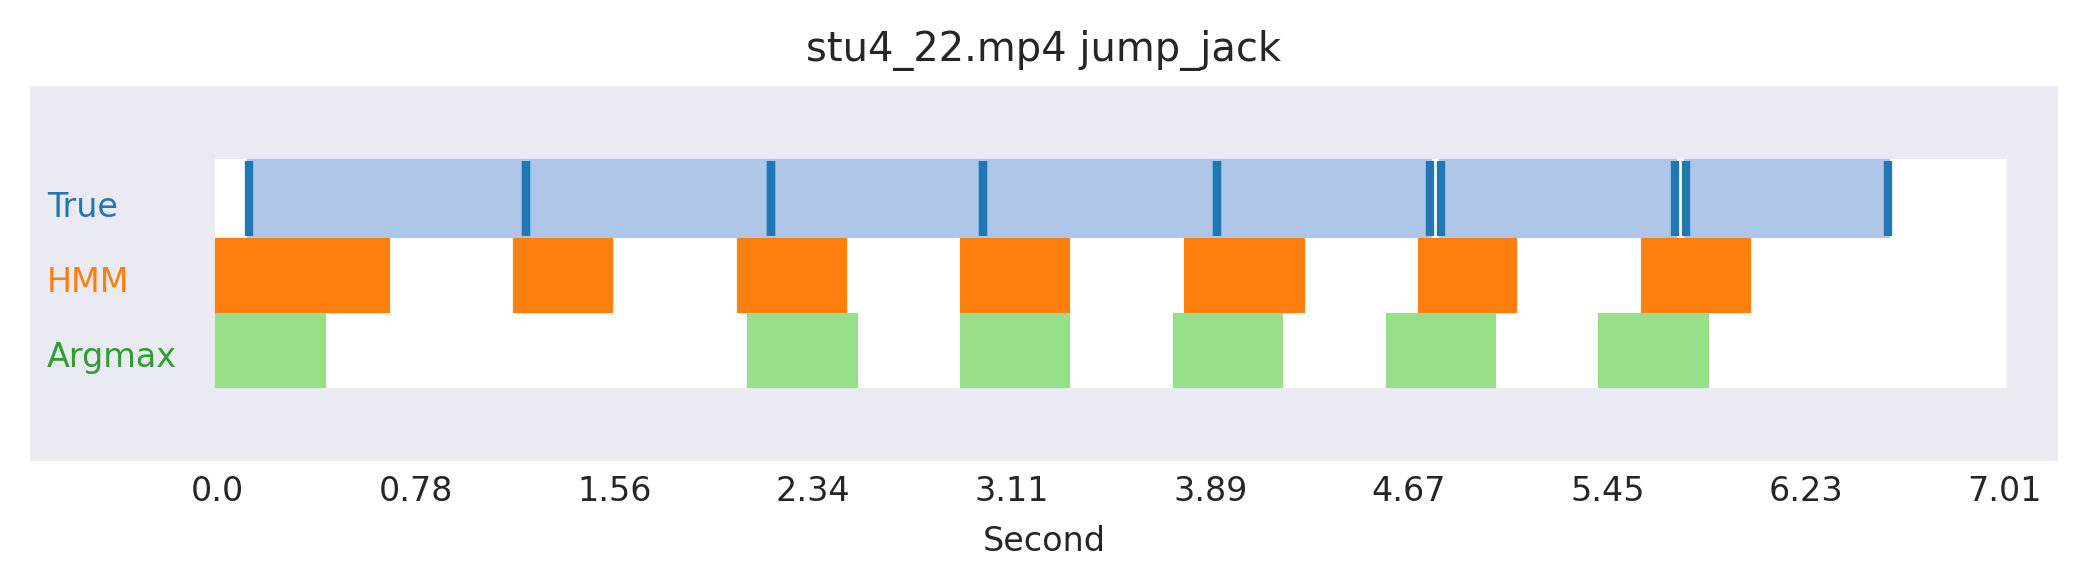

In [7]:
val_data = list(get_rep_data(anno_path, data_root,['val'], [action]).values())
item = random.choice(val_data)

val_x = []
js = json.load(open(osj(json_dir, template.format(item.video_name))))
for i,v in js['scores'].items():
    val_x.append(np.array(list(v.values())))
val_x = np.array(val_x)
class_idx = CLASSES.index(item.class_)
val_y = np.array(reps_to_label(item.reps, item.total_frames, class_idx=0))
print(val_x.shape, val_y[:10])
print('startprob_', model.startprob_.shape)
pred = model.predict(val_x)
print('count', len(js['ground_truth'])//2, 'name', item.video_name, item.class_)
pred_mapped = pred.copy()
# pred_mapped[pred == 0] = 1
pred_smoothed = major_vote(pred-1, window=1)
hmm_count, hmm_reps = pred_to_count(pred_smoothed, stride=1, step=1)
# print('hmm pred', pred)
# Baseline Argmax with threshold 0.6
threshold = 0.6
action_only_x = val_x[:, class_idx*2:class_idx*2+2]
val_x_thre = [np.argmax(vx) if vx.max() >= threshold else -1 for vx in action_only_x]
val_x_thre = np.array(val_x_thre) + 1
val_x_smoothed = major_vote(val_x_thre-1, window=10)
argmax_count, argmax_reps = pred_to_count(val_x_smoothed, stride=1*10, step=1)
print('argmax_smoothed', val_x_smoothed)

title = f'{item.video_name} {item.class_}'
plot_raw_output(val_x, val_y, pred, val_x_thre, class_idx, title)
plot_hmm(hmm_reps, js['ground_truth'], argmax_reps, item.total_frames, item.fps, title)